In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt

import json
import numpy as np
import pandas as pd

import re
import joblib

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Задание

1. Классификатор для вакансий
  - Признаки: векторизованное описание вакансии
  - Целевой: professional_roles или specializations (на выбор)
  1. Разбить на Train/Test
  2. Создать CountVectorizer и TfidfVectorizer для Train, cериализовать и сохранить на диск эти модели
  3. Сделать классификатор
  4. Оценить

2. Регрессор для вакансий
  - Признаки: векторизованное описание вакансии
  - Целевой: зарплатная вилка или средняя з.п. (на выбор)
  1. Использовать CountVectorizer и TfidfVectorizer из пункта 1.
  2. Сделать регрессор
  3. Оценить

3. Проветси кластеризацию
  - Признаки: векторизованное описание вакансии
  1. Использовать CountVectorizer и TfidfVectorizer из пункта 1.
  2. Провести оценку качества: минимум по 1 внутренней и внешней




In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/data_all_comb.csv', index_col='id')
data = data.drop('Unnamed: 3', axis=1)

In [ ]:
print(len(data))
data.head()

14775


json  \
id                                                            
70500101  {"id": "70500101", "premium": false, "billing_...   
70864945  {"id": "70864945", "premium": false, "billing_...   
69720742  {"id": "69720742", "premium": false, "billing_...   
70143108  {"id": "70143108", "premium": false, "billing_...   
70502978  {"id": "70502978", "premium": false, "billing_...   

                                                  prep_desc  
id                                                           
70500101  ["\u043e\u0431\u044f\u0437\u0430\u043d\u043d\u...  
70864945  ["\u043e\u0431\u044f\u0437\u0430\u043d\u043d\u...  
69720742  ["\u043e\u0431\u044f\u0437\u0430\u043d\u043d\u...  
70143108  ["\u043e\u0431\u044f\u0437\u0430\u043d\u043d\u...  
70502978  ["\u043e\u0431\u044f\u0437\u0430\u043d\u043d\u...

In [ ]:
jsons_data_description = list()
jsons_all_data = list()

for j in data['prep_desc'].tolist():
    js = json.loads(j)
    jsons_data_description.append(js)

for j in data['json'].tolist():
    js = json.loads(j)
    jsons_all_data.append(js)

In [ ]:
print(json.dumps(jsons_all_data[1]['salary']))

{"from": 40000, "to": 60000, "currency": "RUR", "gross": true}


In [ ]:
# берем из jsons_all_data целевой признак
data_x = list()
data_y = list()
data_y_regr = list()

for j in jsons_data_description:
    desc = ' '.join(list(j))
    desc = re.sub(r"([[[])|(')|(\s)|([]]])|([0-9])", " ", desc)
    data_x.append(desc)

    
max_count_roles = 0
roles_names = list()
mean_salary_class = dict() # mean_salary_class: {class_id: (sum_salary, class_count)}
for j in jsons_all_data:
    roles = list()
    max_count_roles = max(max_count_roles, len(j['professional_roles']))
    for role in list(j['professional_roles']):
        roles.append(int(role['id']))
        roles_names.append(str(role['name']))
    data_y.append(roles[0]) # максимальное количество ролей в одной вакансии один. Поэтому roles[0]
    if (j['salary'] == None):
        data_y_regr.append(None)
    elif (j['salary']['from'] == None and j['salary']['to'] == None):
        data_y_regr.append(None)
    else:
        mean_salary = 0
        #mean_salary = (int(j['salary']['from']) + int(j['salary']['to'])) / 2
        if (j['salary']['from'] != None):
            mean_salary = (int(j['salary']['from']) * 1.15)
        elif (j['salary']['to'] != None):
            mean_salary = (int(j['salary']['to']) * 0.85)
        data_y_regr.append(mean_salary)
        if(roles[0] in mean_salary_class.keys()):
            mean_salary_class[roles[0]][0] += mean_salary
            mean_salary_class[roles[0]][1] += 1
        else:
            mean_salary_class[roles[0]] = [mean_salary, 1]

# заполняем пропуски в зарплате средней по классу
for k in mean_salary_class.keys():
    mean_salary_class[k] = mean_salary_class[k][0] / mean_salary_class[k][1]
for i in range(len(data_y_regr)):
    if (data_y_regr[i] == None):
        if(data_y[i] in mean_salary_class.keys()):
            data_y_regr[i] = mean_salary_class[data_y[i]]
        else:
            # если у нас нет информации о зарплате в классе, то ставим среднюю зп по РФ
            data_y_regr[i] = 35000 # средняя зп

print(f'data_x len: {len(data_x)}, data_y len: {len(data_y)}, data_y_regr len: {len(data_y_regr)}')

dict_classes = dict()
for c in sorted(data_y):
    if (dict_classes.get(c)):
        dict_classes[c] += 1
    else:
        dict_classes[c] = 1

# выборка несбалансированная, поэтому удалим некоторые классы :)
# удаляем объекты с слишком маленькими описаниями
deleted_classes = list()
for c in dict_classes.keys():
    if (dict_classes.get(c) < 25):
        deleted_classes.append(c)
deleted_classes_count = 0
for i in range(len(data_y)-1, -1, -1):
    if (data_y[i] in deleted_classes):
        data_y.pop(i)
        data_x.pop(i)
        data_y_regr.pop(i)
        deleted_classes_count += 1

print(f'data_x len: {len(data_x)}, data_y len: {len(data_y)}, data_y_regr len: {len(data_y_regr)}')

print('Классы: ', dict_classes)
print('Удалены: ', deleted_classes_count, 'объектов классов: ', deleted_classes)
print('Итого классов после удаления: ', len(set(data_y)), 'шт:', sorted(set(data_y)))

print('Размер выборки: ', len(data_x))

(x_train, x_test, y_train, y_test) = train_test_split(data_x, data_y, test_size=0.3, random_state=0)
(x_train_regr, x_test_regr, y_train_regr, y_test_regr) = train_test_split(data_x, data_y_regr, test_size=0.3, random_state=0)

'''
(x_train, x_test, y_train, y_test) = (list(), list(), list(), list())
now_class = 0
sorted_data_all = sorted(list(zip(data_x, data_y)), key=lambda a: a[1])
print('sorted all data:', sorted_data_all[0: 10])
for i in range(len(sorted_data_all)):
    if(sorted_data_all[i][1] != now_class):
        now_class = sorted_data_all[i][1]
        now_count = 0
    now_count += 1
    if (now_count > dict_classes.get(c) * 0.1):
        x_train.append(sorted_data_all[i][0])
        y_train.append(sorted_data_all[i][1])
    else:
        x_test.append(sorted_data_all[i][0])
        y_test.append(sorted_data_all[i][1])
'''


print(f'len(set(y_train)): {len(set(y_train))}')
print(f'len(set(y_test)): {len(set(y_test))}')

print(f'y_train {len(y_train)}, y_train_regr {len(y_train_regr)}')
print(f'y_test {len(y_test)}, y_test_regr {len(y_test_regr)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Possible nested set at position 2
  


data_x len: 14775, data_y len: 14775, data_y_regr len: 14775
data_x len: 14237, data_y len: 14237, data_y_regr len: 14237
Классы:  {1: 4, 2: 22, 3: 136, 4: 14, 5: 20, 6: 70, 7: 6, 8: 772, 9: 74, 10: 38, 13: 12, 14: 18, 15: 16, 16: 10, 17: 8, 18: 511, 19: 6, 20: 8, 21: 759, 22: 36, 23: 142, 24: 178, 25: 2, 26: 28, 27: 22, 28: 16, 29: 32, 30: 10, 31: 198, 32: 12, 33: 218, 34: 126, 35: 136, 36: 4, 37: 10, 38: 16, 39: 108, 40: 1194, 41: 14, 42: 6, 43: 4, 44: 42, 45: 86, 46: 32, 47: 70, 48: 78, 49: 52, 50: 6, 51: 104, 52: 232, 53: 36, 54: 194, 55: 38, 56: 6, 57: 104, 58: 50, 59: 20, 60: 24, 61: 14, 62: 26, 63: 176, 64: 102, 65: 44, 66: 176, 67: 188, 68: 106, 69: 108, 70: 664, 71: 20, 72: 102, 73: 12, 74: 104, 75: 8, 76: 102, 77: 144, 78: 76, 79: 70, 80: 46, 81: 66, 82: 100, 83: 168, 84: 189, 85: 179, 86: 16, 87: 10, 88: 132, 89: 279, 90: 151, 91: 4, 92: 2, 93: 14, 94: 168, 95: 82, 96: 123, 97: 679, 99: 42, 100: 70, 101: 10, 102: 147, 103: 50, 104: 6, 105: 28, 106: 72, 107: 38, 108: 30, 109:

In [ ]:
print(roles_names)

['Специалист по тендерам', 'Оператор производственной линии', 'Менеджер по туризму', 'Торговый представитель', 'Фотограф, ретушер', 'Продавец-консультант, продавец-кассир', 'Менеджер ресторана', 'Курьер', 'Медицинская сестра, медицинский брат', 'Менеджер по закупкам', 'Руководитель проектов', 'Врач', 'Официант, бармен, бариста', 'Сервисный инженер, инженер-механик', 'Водитель', 'Тестировщик', 'Другое', 'Машинист', 'Упаковщик, комплектовщик', 'Другое', 'Охранник', 'Оператор call-центра, специалист контактного центра', 'Продавец-консультант, продавец-кассир', 'Менеджер по продажам, менеджер по работе с клиентами', 'Бухгалтер', 'Медицинская сестра, медицинский брат', 'Делопроизводитель, архивариус', 'Менеджер по персоналу', 'Продавец-консультант, продавец-кассир', 'Другое', 'Другое', 'Кассир-операционист', 'Упаковщик, комплектовщик', 'Разнорабочий', 'Другое', 'Генеральный директор, исполнительный директор (CEO)', 'Диспетчер', 'Менеджер по продажам, менеджер по работе с клиентами', 'Менедж

### Векторайзеры

In [ ]:
#joblib.dump(data_x, '/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/data_all_x.txt')

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1,3))
b_count = count_vectorizer.fit_transform(x_train)
joblib.dump(count_vectorizer, '/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/vectorizer_count.pkl')

['/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/vectorizer_count.pkl']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
b_tfidf = tfidf_vectorizer.fit_transform(x_train)
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/vectorizer_tfidf.pkl')

['/content/drive/MyDrive/Colab Notebooks/ОЕЯ Данные/vectorizer_tfidf.pkl']

## Классификатор

In [ ]:
models_metrics = dict()

def fiting(model, paramgrid, x_train, y_train):
    gs = GridSearchCV(model, paramgrid)
    print(gs.get_params().keys())
    gs.fit(x_train, y_train);
    print(f'gs.best_params_: {gs.best_params_}\ngs.best_score_: {gs.best_score_}')
    return gs

def print_metrics(y_test, y_pred):
    print('accuracy_score ', accuracy_score(y_test, y_pred))
    print('f1_score       ', f1_score(y_test, y_pred, average='macro'))

count_vectorizer

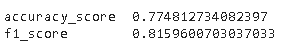

In [ ]:
model = svm.LinearSVC()
model.fit(b_count, y_train)
y_pred = model.predict(count_vectorizer.transform(x_test))

print()
print_metrics(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



accuracy_score  0.7734082397003745
f1_score        0.8142674101549967


tfidf_vectorizer

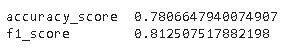

In [ ]:
model = svm.LinearSVC()
model.fit(b_tfidf, y_train)
y_pred = model.predict(tfidf_vectorizer.transform(x_test))

print()
print_metrics(y_pred, y_test)


accuracy_score  0.7823033707865169
f1_score        0.81598326770422


In [ ]:
from sklearn.metrics import classification_report

#print(set(y_pred), set(y_test))
#print(classification_report(y_test, y_pred.tolist()))

In [ ]:
#print(classification_report(data_y, np.zeros(len(data_y))))

## Регрессор

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score

def print_metrics_regr(y_test, y_pred):
    print('mean_absolute_error ', mean_absolute_error(y_test, y_pred))
    print('r2_score            ', r2_score(y_test, y_pred))

count_vectorizer

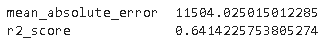

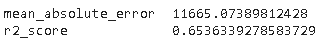

In [ ]:
model = LinearRegression()
model.fit(count_vectorizer.transform(x_train_regr), y_train_regr)

LinearRegression()

In [ ]:
y_pred = model.predict(count_vectorizer.transform(x_test_regr))

print_metrics_regr(y_test_regr, y_pred)

mean_absolute_error  11504.025015012285
r2_score             0.6414225753805274


In [ ]:
model = RidgeCV()
model.fit(count_vectorizer.transform(x_train_regr), y_train_regr)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [ ]:
y_pred = model.predict(count_vectorizer.transform(x_test_regr))

print_metrics_regr(y_test_regr, y_pred)

mean_absolute_error  11665.07389812428
r2_score             0.6536339278583729


tfidf_vectorizer

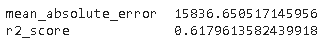

In [ ]:
model = RidgeCV()
model.fit(tfidf_vectorizer.transform(x_train_regr), y_train_regr)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [ ]:
y_pred = model.predict(tfidf_vectorizer.transform(x_test_regr))

print_metrics_regr(y_test_regr, y_pred)

mean_absolute_error  15836.650517145956
r2_score             0.6179613582439918


## Кластеризатор

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score, fowlkes_mallows_score, silhouette_score

count_vectorizer

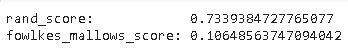

In [ ]:
model_clus = KMeans(n_clusters=len(set(data_y)))
model_clus.fit(count_vectorizer.transform(x_train))

KMeans(n_clusters=93)

In [ ]:
y_pred = model_clus.predict(count_vectorizer.transform(x_test))

print(f'rand_score:            {rand_score(y_test, y_pred)}')
print(f'fowlkes_mallows_score: {fowlkes_mallows_score(y_test, y_pred)}')

rand_score:            0.7339384727765077
fowlkes_mallows_score: 0.10648563747094042


tfidf_vectorizer

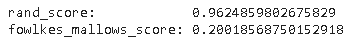

In [ ]:
model_clus = KMeans(n_clusters=len(set(data_y)))
model_clus.fit(tfidf_vectorizer.transform(x_train))

KMeans(n_clusters=93)

In [ ]:
y_pred = model_clus.predict(tfidf_vectorizer.transform(x_test))

print(f'rand_score:            {rand_score(y_test, y_pred)}')
print(f'fowlkes_mallows_score: {fowlkes_mallows_score(y_test, y_pred)}')

rand_score:            0.9624859802675829
fowlkes_mallows_score: 0.20018568750152918


оценка без использования истинных меток

In [ ]:
# оценка без использования истинных меток
score = silhouette_score(tfidf_vectorizer.transform(x_test).todense(), y_pred)
print(f'silhouette_score: {score}') # -0.017954644150964278 средненко :(

silhouette_score: -0.017954644150964278
